# Process
In this notebook, I will analyse the results of the recommendation on the properties.

# A. Import Libraries

In [1]:
import warnings
import pickle as pkl
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
pd.set_option("display.precision", 6)
from cornac.metrics import MAE, MSE, RMSE, Precision, Recall, NDCG, AUC, MAP, FMeasure, MRR
from collections import defaultdict
from scipy import stats
import seaborn as sns
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


# B. Set Hyperparameters

In [2]:
item_threshold = 5 # remove users with less than item_threshold items
user_threshold = 5 # remove items with less than user_threshold users
top_threshold = 200 # remove users who have rated more than top_threshold items
recommendation_type = "books" # books, music or movies
item_col = "book" # the item column
my_seed = 0 # random_seed
top_fraction_items = 0.2 # the limit for an item to be considered popular
top_fraction_users = 0.2# the limit for a user to be considered High Mainstriminess
split_gender_by = "male_female_difference" 
split_country_by = "ratio_USA"
split_by = "pop_fraq"

rd.seed(my_seed)
np.random.seed(my_seed)

These additions will be useful so we can load and save the different files (plots and processed data) with clarity on the hyperparameters.

In [3]:
addition_1 = "_u"+str(item_threshold)+"_i"+str(user_threshold)+"_t"+str(top_threshold)
addition_2 = addition_1 + "_tfi"+str(int(100*top_fraction_items))
addition_3 = addition_2 + "_tfu"+str(int(100*top_fraction_users))
addition_4 = addition_3 + ("_sbpf" if (split_by=="pop_fraq") else "_sbpif")

addition_gender = addition_1 + "_tfu"+str(int(100*top_fraction_users)) + "_mfd"
addition_country = addition_1 + "_tfu"+str(int(100*top_fraction_users)) + "_USAr"

# C. Read Files
Files to read:
1. exp_results & exp_metrics: the Cornac results & metrics
2. training_ids: the user training ids
3. male, female and diverse oriented users
4. low, mid and USA oriented users

In [4]:
raw_file_location = "data/raw/" # here are stored the raw data files
processed_file_location = "data/processed/" # here we store the processed data files

### C1. General results

In [5]:
# Cornac results
with open(processed_file_location+recommendation_type+"/experiment_results_cornac"+addition_4+".pkl", "rb") as f:
    exp_results = pkl.load(f)
with open(processed_file_location+recommendation_type+"/experiment_metrics_cornac"+addition_4+".pkl", "rb") as f:
    exp_metrics = pkl.load(f)

In [6]:
with open(processed_file_location+recommendation_type+"/training_user_ids"+addition_4+".pkl", "rb") as f:
    training_ids = pkl.load(f)

In [7]:
with open(processed_file_location+recommendation_type+"/low_users"+addition_4+".csv", "rb") as f:
    low_users = pd.read_csv(f, index_col=0)
with open(processed_file_location+recommendation_type+"/med_users"+addition_4+".csv", "rb") as f:
    med_users =  pd.read_csv(f, index_col=0)
with open(processed_file_location+recommendation_type+"/high_users"+addition_4+".csv", "rb") as f:
    high_users =  pd.read_csv(f,  index_col=0)

### C2. Gender analysis results

In [8]:
with open(processed_file_location+recommendation_type+"/new_male_oriented.csv", "rb") as f:
    male_oriented_users = pd.read_csv(f, index_col=0)
with open(processed_file_location+recommendation_type+"/new_female_oriented.csv", "rb") as f:
    female_oriented_users =  pd.read_csv(f, index_col=0)
with open(processed_file_location+recommendation_type+"/new_diverse.csv", "rb") as f:
    diverse_users =  pd.read_csv(f,  index_col=0)

### C3. Country analysis results

In [9]:
with open(processed_file_location+recommendation_type+"/new_USA_oriented.csv", "rb") as f:
    USA_oriented_users = pd.read_csv(f, index_col=0)
with open(processed_file_location+recommendation_type+"/new_midUSA_oriented.csv", "rb") as f:
    midUSA_oriented_users =  pd.read_csv(f, index_col=0)
with open(processed_file_location+recommendation_type+"/new_lowUSA_oriented.csv", "rb") as f:
    lowUSA_oriented_users =  pd.read_csv(f,  index_col=0)

## D. Analyze Results

In [21]:
algo_names = ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']

## D.1 Gender

In [11]:
full_dataset_gender = pd.concat([female_oriented_users, male_oriented_users, diverse_users])

In [24]:
for index, row in low_users.iterrows():
    low_users.at[index,"male_female_difference"] = full_dataset_gender.loc[index].male_female_difference
    for alg in algo_names:
        low_users.at[index, "new_male_female_difference_" + alg] = full_dataset_gender.loc[index]["new_male_female_difference_" + alg]

In [26]:
for index, row in med_users.iterrows():
    med_users.at[index,"male_female_difference"] = full_dataset_gender.loc[index].male_female_difference
    for alg in algo_names:
        med_users.at[index, "new_male_female_difference_" + alg] = full_dataset_gender.loc[index]["new_male_female_difference_" + alg]

In [27]:
for index, row in high_users.iterrows():
    high_users.at[index,"male_female_difference"] = full_dataset_gender.loc[index].male_female_difference
    for alg in algo_names:
        high_users.at[index, "new_male_female_difference_" + alg] = full_dataset_gender.loc[index]["new_male_female_difference_" + alg]

### D.1.2 Results per user group

In [29]:
old_avg_high = high_users.male_female_difference.mean()
old_avg_med = med_users.male_female_difference.mean()
old_avg_low = low_users.male_female_difference.mean()

new_avg_high = []
new_avg_med = []
new_avg_low = []
for alg in algo_names:
    high_users["new_male_female_difference_"+alg] = (high_users["new_male_female_difference_"+alg] - high_users.male_female_difference)
    med_users["new_male_female_difference_"+alg] = (med_users["new_male_female_difference_"+alg] - med_users.male_female_difference)
    low_users["new_male_female_difference_"+alg] = (low_users["new_male_female_difference_"+alg] - low_users.male_female_difference)
    
    new_avg_high.append(high_users["new_male_female_difference_"+alg].mean())
    new_avg_low.append(low_users["new_male_female_difference_"+alg].mean())
    new_avg_med.append(med_users["new_male_female_difference_"+alg].mean())

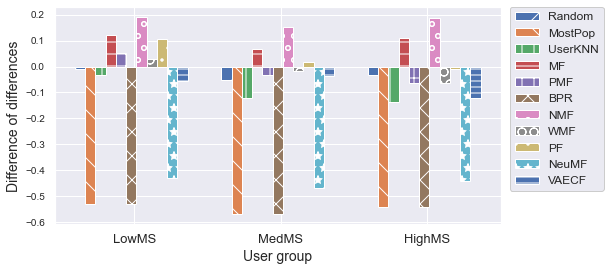

In [30]:
sns.set(rc = {'figure.figsize':(8,4)})

# set width of bar
barWidth = 0.07

# set height of bar
bars1 = [new_avg_low[0], new_avg_med[0], new_avg_high[0]]
bars2 = [new_avg_low[1], new_avg_med[1], new_avg_high[1]]
bars3 = [new_avg_low[2], new_avg_med[2], new_avg_high[2]]
bars4 = [new_avg_low[3], new_avg_med[3], new_avg_high[3]]
bars5 = [new_avg_low[4], new_avg_med[4], new_avg_high[4]]
bars6 = [new_avg_low[5], new_avg_med[5], new_avg_high[5]]
bars7 = [new_avg_low[6], new_avg_med[6], new_avg_high[6]]
bars8 = [new_avg_low[7], new_avg_med[7], new_avg_high[7]]
bars9 = [new_avg_low[8], new_avg_med[8], new_avg_high[8]]
bars10 = [new_avg_low[9], new_avg_med[9], new_avg_high[9]]
bars11 = [new_avg_low[10], new_avg_med[10], new_avg_high[10]]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
r9 = [x + barWidth for x in r8]
r10 = [x + barWidth for x in r9]
r11 = [x + barWidth for x in r10]
# r12 = [x + barWidth for x in r11]
# r13 = [x + barWidth for x in r12]

# ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*", "--"]

# Make the plot
plt.bar(r1, bars1, width=barWidth, label='Random', hatch=patterns[0])
plt.bar(r2, bars2, width=barWidth, label='MostPop', hatch=patterns[1])
plt.bar(r3, bars3, width=barWidth, label='UserKNN', hatch=patterns[2])
plt.bar(r4, bars4, width=barWidth, label='MF', hatch=patterns[3])
plt.bar(r5, bars5, width=barWidth, label='PMF', hatch=patterns[4])
plt.bar(r6, bars6, width=barWidth, label='BPR', hatch=patterns[5])
plt.bar(r7, bars7, width=barWidth, label='NMF', hatch=patterns[6])
plt.bar(r8, bars8, width=barWidth, label='WMF', hatch=patterns[7])
plt.bar(r9, bars9, width=barWidth, label='PF', hatch=patterns[8])
plt.bar(r10, bars10, width=barWidth, label='NeuMF', hatch=patterns[9])
plt.bar(r11, bars11, width=barWidth, label='VAECF', hatch=patterns[10])

# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='14')
plt.ylabel('Difference of differences', fontsize='14')
plt.xticks([r + barWidth + 0.3 for r in range(len(bars1))], ['LowMS', 'MedMS', 'HighMS'], fontsize='13')
plt.yticks(fontsize='10')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='12')
plt.show()
#plt.savefig('gap_analysis.pdf', dpi=300, bbox_inches='tight')

## D.2 Country

In [31]:
full_dataset_country = pd.concat([lowUSA_oriented_users, midUSA_oriented_users, USA_oriented_users])

In [33]:
for index, row in low_users.iterrows():
    low_users.at[index,"ratio_USA"] = full_dataset_country.loc[index].ratio_USA
    for alg in algo_names:
        low_users.at[index, "new_ratio_USA_" + alg] = full_dataset_country.loc[index]["new_ratio_USA_" + alg]

In [34]:
for index, row in med_users.iterrows():
    med_users.at[index,"ratio_USA"] = full_dataset_country.loc[index].ratio_USA
    for alg in algo_names:
        med_users.at[index, "new_ratio_USA_" + alg] = full_dataset_country.loc[index]["new_ratio_USA_" + alg]

In [36]:
for index, row in low_users.iterrows():
    high_users.at[index,"ratio_USA"] = full_dataset_country.loc[index].ratio_USA
    for alg in algo_names:
        high_users.at[index, "new_ratio_USA_" + alg] = full_dataset_country.loc[index]["new_ratio_USA_" + alg]

### D.1.2 Results per user group

In [37]:
old_avg_high = high_users.ratio_USA.mean()
old_avg_med = med_users.ratio_USA.mean()
old_avg_low = low_users.ratio_USA.mean()

new_avg_high = []
new_avg_med = []
new_avg_low = []
for alg in algo_names:
    high_users["new_ratio_USA_"+alg] = (high_users["new_ratio_USA_"+alg] - high_users.ratio_USA)
    med_users["new_ratio_USA_"+alg] = (med_users["new_ratio_USA_"+alg] - med_users.ratio_USA)
    low_users["new_ratio_USA_"+alg] = (low_users["new_ratio_USA_"+alg] - low_users.ratio_USA)
    
    new_avg_high.append(high_users["new_ratio_USA_"+alg].mean())
    new_avg_low.append(low_users["new_ratio_USA_"+alg].mean())
    new_avg_med.append(med_users["new_ratio_USA_"+alg].mean())

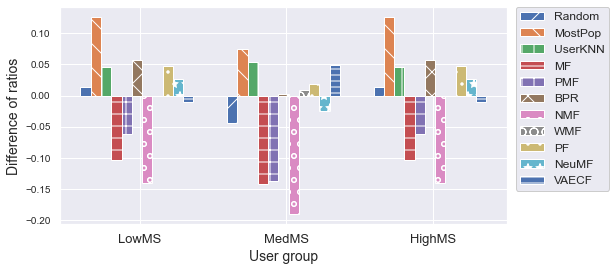

In [38]:
sns.set(rc = {'figure.figsize':(8,4)})

# set width of bar
barWidth = 0.07

# set height of bar
bars1 = [new_avg_low[0], new_avg_med[0], new_avg_high[0]]
bars2 = [new_avg_low[1], new_avg_med[1], new_avg_high[1]]
bars3 = [new_avg_low[2], new_avg_med[2], new_avg_high[2]]
bars4 = [new_avg_low[3], new_avg_med[3], new_avg_high[3]]
bars5 = [new_avg_low[4], new_avg_med[4], new_avg_high[4]]
bars6 = [new_avg_low[5], new_avg_med[5], new_avg_high[5]]
bars7 = [new_avg_low[6], new_avg_med[6], new_avg_high[6]]
bars8 = [new_avg_low[7], new_avg_med[7], new_avg_high[7]]
bars9 = [new_avg_low[8], new_avg_med[8], new_avg_high[8]]
bars10 = [new_avg_low[9], new_avg_med[9], new_avg_high[9]]
bars11 = [new_avg_low[10], new_avg_med[10], new_avg_high[10]]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
r9 = [x + barWidth for x in r8]
r10 = [x + barWidth for x in r9]
r11 = [x + barWidth for x in r10]
# r12 = [x + barWidth for x in r11]
# r13 = [x + barWidth for x in r12]

# ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*", "--"]

# Make the plot
plt.bar(r1, bars1, width=barWidth, label='Random', hatch=patterns[0])
plt.bar(r2, bars2, width=barWidth, label='MostPop', hatch=patterns[1])
plt.bar(r3, bars3, width=barWidth, label='UserKNN', hatch=patterns[2])
plt.bar(r4, bars4, width=barWidth, label='MF', hatch=patterns[3])
plt.bar(r5, bars5, width=barWidth, label='PMF', hatch=patterns[4])
plt.bar(r6, bars6, width=barWidth, label='BPR', hatch=patterns[5])
plt.bar(r7, bars7, width=barWidth, label='NMF', hatch=patterns[6])
plt.bar(r8, bars8, width=barWidth, label='WMF', hatch=patterns[7])
plt.bar(r9, bars9, width=barWidth, label='PF', hatch=patterns[8])
plt.bar(r10, bars10, width=barWidth, label='NeuMF', hatch=patterns[9])
plt.bar(r11, bars11, width=barWidth, label='VAECF', hatch=patterns[10])

# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='14')
plt.ylabel('Difference of ratios', fontsize='14')
plt.xticks([r + barWidth + 0.3 for r in range(len(bars1))], ['LowMS', 'MedMS', 'HighMS'], fontsize='13')
plt.yticks(fontsize='10')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='12')
plt.show()
#plt.savefig('gap_analysis.pdf', dpi=300, bbox_inches='tight')